# k-infinity calculation - homogeneous problem

The reason we need to use production scattering cross section in neutron balance equation.

## Setup python

In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

import openmc
from openmc.statepoint import StatePoint

%matplotlib inline

## Load some nuclides

In [2]:
h1 = openmc.Nuclide('H-1')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')

## Create fuel and moderator materials

In [3]:
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)
fuel.add_nuclide(h1, 9.2000e-2)

## Create materials object and export

In [4]:
materials_file = openmc.MaterialsFile()
materials_file.add_material(fuel)
materials_file.default_xs = '71c'

materials_file.export_to_xml()

## Create surfaces

In [5]:
min_x = openmc.XPlane(x0=-1.0, boundary_type='reflective')
max_x = openmc.XPlane(x0=+1.0, boundary_type='reflective')
min_y = openmc.YPlane(y0=-1.0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+1.0, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-1.0, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+1.0, boundary_type='reflective')

## Create root cell and geometry

In [6]:
root_cell = openmc.Cell(name='root cell')
root_cell.fill = fuel

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

## Create geometry file and export

In [7]:
geometry_file = openmc.GeometryFile()
geometry_file.geometry = geometry

geometry_file.export_to_xml()

## Set OpenMC settings and export file

In [8]:
# OpenMC simulation parameters
batches = 100
inactive = 10
particles = 50000

# Instantiate a SettingsFile
settings_file = openmc.SettingsFile()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
source_bounds = [min_x.x0, min_y.y0, min_z.z0, max_x.x0, max_y.y0, max_z.z0]
settings_file.set_source_space('box', source_bounds)

# Export to "settings.xml"
settings_file.export_to_xml()

## Plot geometry

In [9]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'slab_geometry'
plot.origin = [0, 0, 0]
plot.width = [2.0, 2.0]
plot.pixels = [200, 200]
plot.color = 'mat'
plot.col_spec={fuel.id:(0, 255, 0)}

# Instantiate a PlotsFile, add Plot, and export to "plots.xml"
plot_file = openmc.PlotsFile()
plot_file.add_plot(plot)
plot_file.export_to_xml()

## Run OpenMC to create plot

In [10]:
executor = openmc.Executor()
executor.plot_geometry(output=False)

0

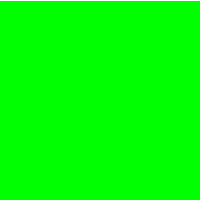

In [11]:
# Convert OpenMC's ppm to png
!convert slab_geometry.ppm slab_geometry.png

# Display the materials plot inline
Image(filename='slab_geometry.png')

## Create tallies

In [12]:
# Instantiate an empty TalliesFile
tallies_file = openmc.TalliesFile()

# Create mesh tally to score flux and fission rate (defaults to analog estimator because of nu-scatter)
tally = openmc.Tally(name='Reaction Rates')
tally.add_score('flux')
tally.add_score('total')
tally.add_score('absorption')
tally.add_score('scatter')
tally.add_score('nu-fission')
tally.add_score('nu-scatter')
tallies_file.add_tally(tally)

# Export to "tallies.xml"
tallies_file.export_to_xml()

## Run OpenMC Simulation

In [13]:
executor.run_simulation()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2015 Massachusetts Institute of Technology
      License:        http://mit-crpg.github.io/openmc/license.html
      Version:        0.7.0
      Git SHA1:       8f2b7b02fc7b7225f32ffd022c5fc9280e1380a5
      Date/Time:      2015-12-05 11:52:28
      MPI Processes:  1
      OpenMP Threads: 8



0

## Extract tallies

In [14]:
# Load the statepoint file
sp = StatePoint('statepoint.100.h5')

# Extract eigenvalue
k_openmc = sp.k_combined

# Get tally from file
tally = sp.get_tally(scores=['flux'])
tally= sp.get_tally(scores=['nu-scatter'])

# Extract tallies
nu_fission_rate = tally.get_slice(scores=['nu-fission'])
absorption_rate = tally.get_slice(scores=['absorption'])

sp.close()

## Calculate k-infinity as described in textbooks

Balance equation for infinite homogeneous system is:

$\Sigma_t\phi = \Sigma_s\phi + \frac{1}{k}\nu\Sigma_f\phi$

This solving for k:

$k = \frac{\nu\Sigma_f\phi}{\Sigma_t\phi - \Sigma_s\phi} = \frac{\nu\Sigma_f\phi}{\Sigma_a\phi}$

The tallies coming from OpenMC for nu-fission and absorption are rates which means they also include volume of geometry. This will cancel from numerator and denominator and will have the formula above.

In [15]:
kinf = nu_fission_rate / absorption_rate

print "k-inf is {}".format(kinf.mean[0,0,0])

k-inf is 1.1579656894


## Difference from k-effective calculated from code

In [16]:
print "Approximate Difference in pcm: {}".format(np.abs(kinf.mean[0,0,0] - k_openmc[0])*10**5)

Approximate Difference in pcm: 255.99422607


What is causing this significant difference? Are we missing physics in the balance equation that OpenMC is capturing? Hint: There are other sources of neutrons other than fission.

## The correct neutron balance equation

We need to capture neutron production from (n, 2n), (n, 3n) ... (n, xn). OpenMC treats this physics with the scattering, but the "scatter" tally score in OpenMC does not record the fact that extra neutrons were produced. Therefore, we created an additional tally score in OpenMC termed "nu-scatter". Its derivation is below.

Start with the correct balance equation accounting for neutron production in (n , xn):

$\Sigma_t\phi = \Sigma_s\phi + \sum\limits_ii\Sigma_{(n, in)}\phi + \frac{1}{k}\nu\Sigma_f\phi$

Include (n, xn) production term in scattering matrix:

$\Sigma_t\phi = \left(\Sigma_s + \sum\limits_ii\Sigma_{(n, in)}\right)\phi + \frac{1}{k}\nu\Sigma_f\phi$
$\Sigma_t\phi = \nu\Sigma_s\phi + \frac{1}{k}\nu\Sigma_f\phi$

where the production scattering rate termed "nu-scatter" in OpenMC is $\nu\Sigma_s\phi$.

Now, k-infinity is calculated using:

$k = \frac{\nu\Sigma_f\phi}{\Sigma_t\phi - \nu\Sigma_s\phi}$

It should be noted that we do not defined an equivalent absorption rate here. We just use the total and nu-scatter scores. Some codes have calculated an absorption rate using the production scattering rate and have termed it "negative" or "reduced" absorption.

## Calculate Correct k-infinity

In [18]:
# Extract total and nu-scatter scores
total_rate = tally.get_slice(scores=['total'])
nu_scatter_rate = tally.get_slice(scores=['nu-scatter'])

# calculate k-inf
kinf = nu_fission_rate / (total_rate - nu_scatter_rate)

print "k-inf is {}".format(kinf.mean[0,0,0])

# difference from OpenMC
print "Approximate Difference in pcm: {}".format(np.abs(kinf.mean[0,0,0] - k_openmc[0])*10**5)

k-inf is 1.16015939107
Approximate Difference in pcm: 36.6240593545


We are much closer now, and the difference is because analog tally estimators were used and we are comparing to OpenMC's statistically combined k.